### Run this code with the Exp_2_WithObstacles.ttt Scene open

## Villela-Braitenberg

In [2]:
from __future__ import print_function
import gym
import gym_kheperaposition
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

Wmax=math.pi/4
Kr_Prop=0.025   
K1=0.1
Kp=0.75
Ki=0.00007 
PI=3.1415

Vmax=0.05
Wmax=math.pi/4
L=0.1
Kr_V_RL=0.05   # radio de seguridad
# mostrar el entorno

noDetectionDistance=0.2 

# Parametros para Braintenberg
braitFrontSens_leftMotor=[5,3,2]       
braitFrontSens_rightMotor=[-5,-3,-2]
braitSideSens_leftMotor=[6,-6]
braitFrontLateralSens_leftMotor=[4,-4]

def BraitenbergControl(v,w,S):

    S = [(abs(sensor-1)*0.2)  for sensor in S]
    Vri=(2*v+w*0.1)/2     
    Vle=(2*v-w*0.1)/2

    if S[3]==noDetectionDistance:
        if S[2]+S[4]+S[1]+S[5]<=noDetectionDistance*4:
            if S[1]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitSideSens_leftMotor[0]*(1-(S[1]/noDetectionDistance))                   
                Vri = Vri + Vmax*braitSideSens_leftMotor[1]*(1-(S[1]/noDetectionDistance))
            if S[2]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitFrontLateralSens_leftMotor[0]*(1-(S[2]/noDetectionDistance))                    
                Vri = Vri + Vmax*braitFrontLateralSens_leftMotor[1]*(1-(S[2]/noDetectionDistance))            
            if S[4]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitFrontLateralSens_leftMotor[1]*(1-(S[4]/noDetectionDistance))                    
                Vri = Vri + Vmax*braitFrontLateralSens_leftMotor[0]*(1-(S[4]/noDetectionDistance))                
            if S[5]>0.25*noDetectionDistance:
                Vle = Vle + Vmax*braitSideSens_leftMotor[1]*(1-(S[5]/noDetectionDistance))
                Vri = Vri + Vmax*braitSideSens_leftMotor[0]*(1-(S[5]/noDetectionDistance))
    else:
        for i in range(3):
            Vle = Vle + Vmax*braitFrontSens_leftMotor[i]*(1-(S[i+2]/noDetectionDistance))
            Vri = Vri + Vmax*braitFrontSens_rightMotor[i]*(1-(S[i+2]/noDetectionDistance))
            
    lineal=(Vri+Vle)/2
    angular=(Vri-Vle)/0.1
        
    if angular>Wmax:
        angular=Wmax
    if angular<-Wmax:
        angular=-Wmax

    return(lineal,angular) 
 

def Villela_agent(steps=1100, angle=0):
    episode_reward = 0
    ErrorAcumulado=0
    env = gym.make('KheperaPositionObstacle-v0')
    env.MaxSteps = steps
    env.Randomize = False
    env.RobotOrientationRand = False
    env.radius = 0.95
    x,y = env.change_target_angle(angle)
    #env.change_target_angle(45)
    state = env.reset()
    d,Oc,vp,wp,s1,s2,s3,s4,s5,s6,s7,s8 = state
    sensors = [s1,s2,s3,s4,s5,s6,s7,s8]
    #env.render()
    ISE_acumulado = 0
    IAE_acumulado = 0
    ITSE_acumulado = 0
    ITAE_acumulado = 0
    
    data = {}
    paso = []
    infoOc = []
    infoD = []
    Lineal = []
    Angular = []
    xc = []
    yc = []

    
    for e in range(steps):
        
        w = Wmax*math.sin(Oc)
        if d > Kr_V_RL:
            v = Vmax
        else:
            v = d*(Vmax/Kr_V_RL)
        if d < 0.02:
            v = 0
            w = 0
        v,w = BraitenbergControl(v,w,sensors)
        
        if d < Kr_Prop:
            v = 0
            w = 0
        
        v = v/Vmax
        w = w/Wmax
        
        action = [v,w]
        state, reward, done, info = env.step(action)
        d,Oc,vp,wp,s1,s2,s3,s4,s5,s6,s7,s8 = state
        sensors = [s1,s2,s3,s4,s5,s6,s7,s8]
        #env.render()
        #print(reward)
        print(reward, end='\r')
        sys.stdout.flush()

        episode_reward += reward
        x = info['xc']
        y = info['yc']
        
        paso.append(e)
        infoOc.append(float(Oc))
        infoD.append(float(d))
        Lineal.append(float(v))
        Angular.append(float(w))
        xc.append(float(x))
        yc.append(float(y))
             
        if done:
            print('Reward of the episode is: ',episode_reward)
            break
    env.close()
   
    data={'paso' : paso,
          'Oc' : infoOc,
          'Distance' : infoD,
          'Lineal' : Lineal,
          'Angular' : Angular,
          'xc' : xc,
          'yc' : yc}
    
    #print(data)
    return data

def indices_rendimiento(data):   
    d, t = [np.array(data['Distance']), 0.05*np.array(data['paso'])]

    IAE = np.trapz(abs(d),t)
    ISE = np.trapz(d**2,t)
    ITAE = np.trapz(t*abs(d),t)
    ITSE = np.trapz(t*(d**2),t)
    
    return IAE,ISE,ITAE,ITSE

In [3]:
Villela_178 = Villela_agent(1100, 178)
Villela_135 = Villela_agent(1100, 135)
Villela_45 = Villela_agent(1100, 45)

Connected to remote API server
Reward of the episode is:  -516.0473360820725
Connected to remote API server
Reward of the episode is:  -127.69136825660098
Connected to remote API server
Reward of the episode is:  -98.31760908668417


# DQN

In [4]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
env.MaxSteps = 1200
env.radius = 0.95
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]
env.change_target_angle(45)
env.Randomize = False
env.RobotOrientationRand = False

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')

log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(178)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
DQN_178 = pickle.load(f)
f.close()
env.close()

Connected to remote API server
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)

In [5]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
env.MaxSteps = 1200
env.radius = 0.95
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]
env.change_target_angle(45)
env.Randomize = False
env.RobotOrientationRand = False

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')

log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(135)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
DQN_135 = pickle.load(f)
f.close()
env.close()

Connected to remote API server
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               6656      
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_6 (Activatio

In [6]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
env.MaxSteps = 1200
env.radius = 0.95
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]
env.change_target_angle(45)
env.Randomize = False
env.RobotOrientationRand = False

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')

log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(45)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
DQN_45 = pickle.load(f)
f.close()
env.close()

Connected to remote API server
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               6656      
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_10 (Activati

## DDPG

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.Randomize = False
env.MaxSteps = 1200
env.radius = 0.95
env.change_target_angle(45)
env.Randomize = False
env.change_target_angle(45)
env.RobotOrientationRand = False

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(178)
agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
ddpg_178 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          6656        flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          262656      dense_12[0][0]                   
________________________________________________________

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.Randomize = False
env.MaxSteps = 1200
env.radius = 0.95
env.change_target_angle(45)
env.Randomize = False
env.change_target_angle(45)
env.RobotOrientationRand = False

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(135)
agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
ddpg_135 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 512)          6656        flatten_5[0][0]                  
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 512)          262656      dense_21[0][0]                   
_______________________________________________________

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.Randomize = False
env.MaxSteps = 1200
env.radius = 0.95
env.change_target_angle(45)
env.Randomize = False
env.change_target_angle(45)
env.RobotOrientationRand = False

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(45)
agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
ddpg_45 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 512)          6656        flatten_7[0][0]                  
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 512)          262656      dense_30[0][0]                   
_______________________________________________________

## Gráficos de Tryectoria multiple

In [10]:
x3,y3 = [Villela_178['xc'],Villela_178['yc']]
x4,y4 = [Villela_135['xc'],Villela_135['yc']]
x5,y5 = [DQN_135['xc'],DQN_135['yc']]
x6,y6 = [DQN_178['xc'],DQN_178['yc']]
x7,y7 = [ddpg_135['xc'],ddpg_135['yc']]
x8,y8 = [ddpg_178['xc'],ddpg_178['yc']]

x10,y10 = [Villela_45['xc'],Villela_45['yc']]
x11,y11 = [DQN_45['xc'],DQN_45['yc']]
x12,y12 = [ddpg_45['xc'],ddpg_45['yc']]

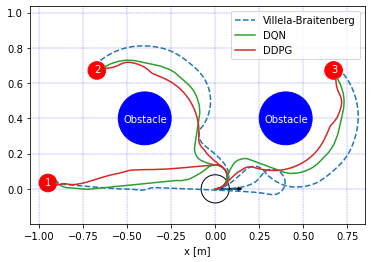

In [11]:
def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def set_ymargin(ax, up=0.0, down=0.3):
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    up = lim[0] - delta*up
    down = lim[1] + delta*down
    ax.set_ylim(up, down)
    
fig, ax = plt.subplots(figsize=(6,4))

x = math.cos(math.radians(178))*0.95
y = math.sin(math.radians(178))*0.95
circle = plt.Circle((x,y), .05, color='r')
ax.text(x-0.015,y-0.01, '1', color='white')
circle2 = plt.Circle((0,0), 0.08, color='k', fill=False)
x = math.cos(math.radians(135))*0.95
y = math.sin(math.radians(135))*0.95
circle3 = plt.Circle((x,y), .05, color='r')
ax.text(x-0.015,y-0.01, '2', color='white')
x = math.cos(math.radians(45))*0.95
y = math.sin(math.radians(45))*0.95

circle4 = plt.Circle((x,y), .05, color='r')
ax.text(x-0.015,y-0.01, '3', color='white')
ax.arrow(0, 0, 0.13, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')
obstacle = plt.Circle((-0.4,0.4), 0.15, color='b')
ax.text(-0.52,0.38, 'Obstacle', color='white')
obstacle_2 = plt.Circle((0.4,0.4), 0.15, color='b')
ax.text(0.28,0.38, 'Obstacle', color='white')
ax.add_artist(circle)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(obstacle)
ax.add_artist(obstacle_2)
ax.plot(x3,y3, '--',color='tab:blue')
ax.plot(x4,y4, '--',color='tab:blue')
ax.plot(x6,y6, color='tab:green')
ax.plot(x5,y5, color='tab:green')
ax.plot(x8,y8, color='tab:red')
ax.plot(x7,y7, color='tab:red')

ax.plot(x10,y10, '--',label='Villela-Braitenberg', color='tab:blue')
ax.plot(x11,y11, label='DQN', color='tab:green')
ax.plot(x12,y12, label='DDPG', color='tab:red')

ax.legend(loc= 'upper right')
ax.axis('equal')
ax.set_xlabel('x [m]')
#set_xmargin(ax, left=0.08, right=0.06)
set_ymargin(ax, up=0, down=0.07)
ax.set_xlim(-1.05, 0.85)
ax.grid(color='b', ls = '-.', lw = 0.25)
#fig.savefig('Trajectories_all_obstacle.svg', format='svg', dpi=1200)
#fig.show()

# Indices de Rendimiento

In [12]:
IR_dqn_178 = indices_rendimiento(DQN_178)
IR_dqn_135 = indices_rendimiento(DQN_135)
IR_ddpg_178 = indices_rendimiento(ddpg_178)
IR_ddpg_135 = indices_rendimiento(ddpg_135)
IR_villela_178 = indices_rendimiento(Villela_178)
IR_villela_135 = indices_rendimiento(Villela_135)
IR_dqn_45 = indices_rendimiento(DQN_45)
IR_ddpg_45 = indices_rendimiento(ddpg_45)
IR_villela_45 = indices_rendimiento(Villela_45)

In [13]:
from tabulate import tabulate
Index = ['ISE','IAE','ITSE','IATE']
PerformanceIndex_178 = {'Index':Index,
                    'Villela':IR_villela_178,
                    'DQN': IR_dqn_178,
                    'DDPG' : IR_ddpg_178}

print('Experimental Data 178°')
print('')
print(tabulate(PerformanceIndex_178, headers='keys'))
print('')

PerformanceIndex_135 = {'Index':Index,
                    'Villela':IR_villela_135,
                    'DQN': IR_dqn_135,
                    'DDPG' : IR_ddpg_135}

print('Experimental Data 135°')
print('')
print(tabulate(PerformanceIndex_135, headers='keys'))
print('')

PerformanceIndex_45 = {'Index':Index,
                    'Villela':IR_villela_45,
                    'DQN': IR_dqn_45,
                    'DDPG' : IR_ddpg_45}

print('Experimental Data 45°')
print('')
print(tabulate(PerformanceIndex_45, headers='keys'))
print('')

Experimental Data 178°

Index      Villela       DQN      DDPG
-------  ---------  --------  --------
ISE        30.2507   13.729    13.3693
IAE        30.7799   10.3637   10.0459
ITSE      414.512   111.33    106.016
IATE      360.439    65.5086   61.7376

Experimental Data 135°

Index      Villela        DQN       DDPG
-------  ---------  ---------  ---------
ISE        16.484    14.5087    12.9644
IAE        11.3621    9.99399    8.94303
ITSE      176.296   136.297    108.425
IATE       96.556    73.7249    57.5937

Experimental Data 45°

Index      Villela        DQN      DDPG
-------  ---------  ---------  --------
ISE       15.2521    13.237    11.4406
IAE        9.89338    8.47784   7.28099
ITSE     161.149    122.385    91.589
IATE      85.5253    62.6917   45.3127



In [14]:
Index = []

for i in range(4):
    Villela = (IR_villela_45[i] + IR_villela_135[i] + IR_villela_178[i])/3
    DQN = (IR_dqn_45[i] + IR_dqn_135[i] + IR_dqn_178[i])/3
    DDPG = (IR_ddpg_45[i] + IR_ddpg_135[i] + IR_ddpg_178[i])/3
    
    Index.append([Villela, DQN, DDPG])
print(Index)
Index =np.transpose(Index)


[[20.662288976085183, 13.82491815493474, 12.59140648205778], [17.34510375402942, 9.611843719077813, 8.756655748657533], [250.6523157432023, 123.33731899751429, 102.00983433055207], [180.83992343630987, 67.30839261868, 54.88130752550655]]


In [15]:
def aproximar(algoritmo):
    for i in range(len(algoritmo)):
        algoritmo[i] = round(algoritmo[i], 2)
    return algoritmo

Index[0] = aproximar(Index[0])
Index[1] = aproximar(Index[1])
Index[2] = aproximar(Index[2])

In [16]:
keys = ['ISE','IAE','ITSE','IATE']

PerformanceIndexProm = {'Index':keys,
                    'Villela':Index[0],
                    'DQN': Index[1],
                    'DDPG' : Index[2]}

print('Experimental Data promedio')
print('')
print(tabulate(PerformanceIndexProm, headers='keys'))
print('')

Experimental Data promedio

Index      Villela     DQN    DDPG
-------  ---------  ------  ------
ISE          20.66   13.82   12.59
IAE          17.35    9.61    8.76
ITSE        250.65  123.34  102.01
IATE        180.84   67.31   54.88



In [17]:
tiempo_Villela_178 = (len(Villela_178['paso'])*0.05)
tiempo_Villela_135 = (len(Villela_135['paso'])*0.05)
tiempo_Villela_45 = (len(Villela_45['paso'])*0.05)

Tiempo_Villela = (tiempo_Villela_45+tiempo_Villela_135+tiempo_Villela_178)/3

tiempo_DQN_178 = (len(DQN_178['paso'])*0.05)
tiempo_DQN_135 = (len(DQN_135['paso'])*0.05)
tiempo_DQN_45 = (len(DQN_45['paso'])*0.05)

Tiempo_DQN = (tiempo_DQN_45+tiempo_DQN_135+tiempo_DQN_178)/3

tiempo_ddpg_178 = (len(ddpg_178['paso'])*0.05)
tiempo_ddpg_135 = (len(ddpg_135['paso'])*0.05)
tiempo_ddpg_45 = (len(ddpg_45['paso'])*0.05)

Tiempo_ddpg = (tiempo_ddpg_45+tiempo_ddpg_135+tiempo_ddpg_178)/3

Algoritmos = ['Villela', 'DQN', 'DDPG']

TP_1 = [tiempo_Villela_178, tiempo_DQN_178, tiempo_ddpg_178]
TP_2 = [tiempo_Villela_135, tiempo_DQN_135, tiempo_ddpg_135]
TP_3 = [tiempo_Villela_45, tiempo_DQN_45, tiempo_ddpg_45]
Prom = [Tiempo_Villela, Tiempo_DQN, Tiempo_ddpg]

Tiempos = {'algoritmos' : Algoritmos,
           'TP_1' : TP_1,
           'TP_2' : TP_2,
           'TP_3' : TP_3,
           'Promedio' : Prom}

print('Tiempos de llegada a los TPs promedio')
print('')
print(tabulate(Tiempos, headers='keys'))
print('')

Tiempos de llegada a los TPs promedio

algoritmos      TP_1    TP_2    TP_3    Promedio
------------  ------  ------  ------  ----------
Villela        36.3    28.85   27.9      31.0167
DQN            22.95   25.65   24.8      24.4667
DDPG           22.55   23.4    22.15     22.7

